Market Data Date Range: 2020-01-03 00:00:00 to 2024-11-12 00:00:00
Asset Returns Date Range: 2020-01-03 00:00:00 to 2023-12-29 00:00:00
Aligned Market Data Date Range: 2020-01-03 00:00:00 to 2023-12-29 00:00:00
Aligned Asset Returns Date Range: 2020-01-03 00:00:00 to 2023-12-29 00:00:00


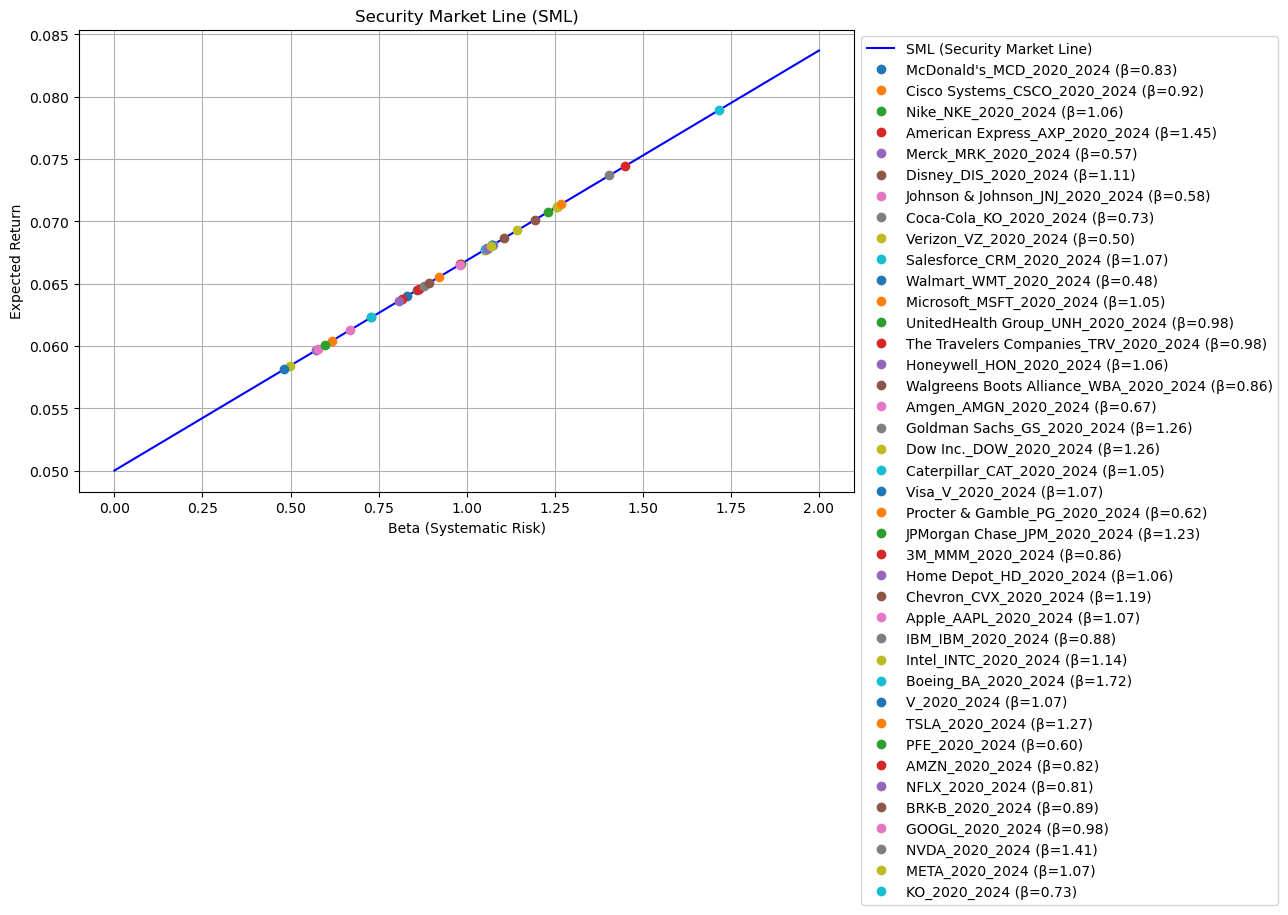

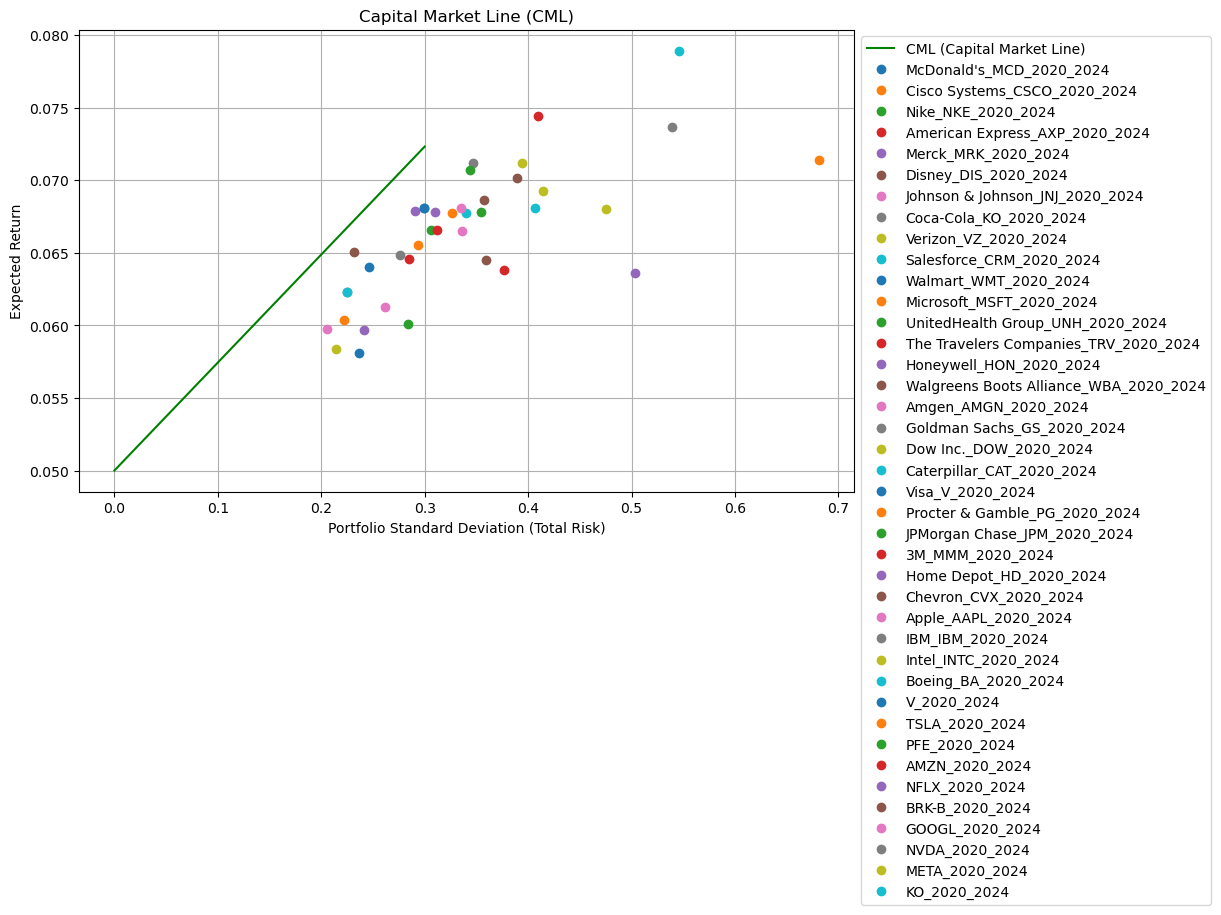

In [18]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Constants
risk_free_rate = 0.05  # Assume a 2% risk-free rate
market_folder = '../Fetch_data/data/indices'
us_30_folder = '../Fetch_data/data/US-30'
extra10_folder = '../Fetch_data/data/Extra10'

# Load Market Data (Dow Jones as Market Proxy)
market_data = pd.read_csv(os.path.join(market_folder, 'DOW_JONES_2020_2024.csv'), parse_dates=['Date'], index_col='Date')

# Calculate Log Return for market data
if 'Adj Close' in market_data.columns:
    market_data['Log Return'] = np.log(market_data['Adj Close'] / market_data['Adj Close'].shift(1))
else:
    raise KeyError("Column 'Adj Close' not found in market data for calculating log returns.")

# Drop any NaN values from Log Return
market_data = market_data.dropna(subset=['Log Return'])

# Print date range of market_data
print("Market Data Date Range:", market_data.index.min(), "to", market_data.index.max())

# Load Asset Data from US-30 and Extra10 folders
def load_asset_data(folder_path):
    asset_data = {}
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv'):
            df = pd.read_csv(os.path.join(folder_path, file_name), parse_dates=['Date'], index_col='Date')
            asset_name = file_name.replace('.csv', '')
            if 'Adj Close' in df.columns:
                df['Log Return'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))
                asset_data[asset_name] = df['Log Return']  # Only keep Log Return for each asset
            else:
                raise KeyError(f"Column 'Adj Close' not found in {file_name} for calculating log returns.")
    return pd.DataFrame(asset_data)

# Load returns data for all assets
us_30_returns = load_asset_data(us_30_folder)
extra10_returns = load_asset_data(extra10_folder)

# Combine all asset returns
asset_returns = pd.concat([us_30_returns, extra10_returns], axis=1)

# Drop any NaN values from asset returns
asset_returns = asset_returns.dropna()

# Print date range of asset_returns
print("Asset Returns Date Range:", asset_returns.index.min(), "to", asset_returns.index.max())

# Find overlapping date range between market_data and asset_returns
start_date = max(market_data.index.min(), asset_returns.index.min())
end_date = min(market_data.index.max(), asset_returns.index.max())

# Slice both DataFrames to the overlapping date range
market_data = market_data.loc[start_date:end_date]
asset_returns = asset_returns.loc[start_date:end_date]

# Re-check the alignment and data
print("Aligned Market Data Date Range:", market_data.index.min(), "to", market_data.index.max())
print("Aligned Asset Returns Date Range:", asset_returns.index.min(), "to", asset_returns.index.max())

# Verify that aligned data is not empty
if market_data.empty or asset_returns.empty:
    raise ValueError("After slicing, one or both DataFrames are still empty. Check date ranges.")

# Calculate Beta and Expected Return for Each Asset
assets = {}
for asset in asset_returns.columns:
    # Calculate Beta using linear regression (asset returns vs market returns)
    beta, _, _, _, _ = linregress(market_data['Log Return'], asset_returns[asset])
    
    # Calculate expected return using CAPM
    expected_return = risk_free_rate + beta * (market_data['Log Return'].mean() * 252 - risk_free_rate)
    assets[asset] = {'beta': beta, 'expected_return': expected_return}

# Convert assets data to DataFrame for plotting
asset_df = pd.DataFrame(assets).T

# Plot Security Market Line (SML)
plt.figure(figsize=(10, 6))
betas = np.linspace(0, 2, 50)
sml_returns = risk_free_rate + betas * (market_data['Log Return'].mean() * 252 - risk_free_rate)
plt.plot(betas, sml_returns, label="SML (Security Market Line)", color='blue')

# Plot each asset on the SML
for asset, data in assets.items():
    plt.plot(data['beta'], data['expected_return'], 'o', label=f"{asset} (β={data['beta']:.2f})")

plt.xlabel("Beta (Systematic Risk)")
plt.ylabel("Expected Return")
plt.title("Security Market Line (SML)")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

# Calculate Volatility for Each Asset and Plot Capital Market Line (CML)
volatilities = asset_returns.std() * np.sqrt(252)  # Annualized volatility
market_std = market_data['Log Return'].std() * np.sqrt(252)  # Annualized market volatility

# Calculate CML slope (Market Sharpe Ratio)
market_sharpe_ratio = (market_data['Log Return'].mean() * 252 - risk_free_rate) / market_std

# Plot Capital Market Line (CML)
plt.figure(figsize=(10, 6))
std_devs = np.linspace(0, 0.3, 50)
cml_returns = risk_free_rate + market_sharpe_ratio * std_devs
plt.plot(std_devs, cml_returns, label="CML (Capital Market Line)", color='green')

# Plot each asset on the CML using its volatility
for asset in asset_df.index:
    plt.plot(volatilities[asset], asset_df.loc[asset, 'expected_return'], 'o', label=f"{asset}")

plt.xlabel("Portfolio Standard Deviation (Total Risk)")
plt.ylabel("Expected Return")
plt.title("Capital Market Line (CML)")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()
